### Qcodes example notebook for Alazar card ATS9360 and acq controllers

In [1]:
import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
from qcodes.instrument_drivers.AlazarTech.acq_controllers import ATS9360Controller
from qcodes.station import Station
#import qcodes.instrument_drivers.AlazarTech.samp_controller as samp_acq_contr
#import qcodes.instrument_drivers.AlazarTech.ave_controller_test as ave_acq_controller
#import qcodes.instrument_drivers.AlazarTech.rec_controller_test as record_acq_controller

import logging
# logging.basicConfig(filename='example.log',level=logging.INFO)

qc.halt_bg()

No loop running


NB: See ATS9360 example notebook for general commands 

In [2]:
# Create the ATS9360 instrument
alazar = ATSdriver.AlazarTech_ATS9360(name='Alazar')
# Print all information about this Alazar card
alazar.get_idn()

{'CPLD_version': '25.16',
 'SDK_version': '5.10.22',
 'asopc_type': '1645511520',
 'bits_per_sample': 12,
 'driver_version': '5.10.22',
 'firmware': None,
 'latest_cal_date': '25-01-17',
 'max_samples': 4294967294,
 'memory_size': '4294967294',
 'model': 'ATS9360',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8',
 'serial': '970396',
 'vendor': 'AlazarTech'}

In [3]:
alazar._handle

752

In [4]:
# Configure all settings in the Alazar card
alazar.config(clock_source='INTERNAL_CLOCK',
              sample_rate=500000000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='CHANNEL_A',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=128,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=1,
              aux_io_mode='AUX_IN_AUXILIARY', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='NONE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

### Basic Acquisition

Pulls the raw data the alazar acquires averaged over number of records buffers.

In [5]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to.
myctrl = ATS9360Controller(name='my_controller', alazar_name='Alazar')

In [6]:
station = qc.Station(alazar, myctrl)

In [7]:
myctrl.int_delay(2e-7)
myctrl.int_time(2e-6)
myctrl.num_avg(100)

start 0 stop 1 num steps 1
start 0 stop 2e-07 num steps 1152


In [8]:
myctrl.parameters['records_per_buffer'].get()

100

In [9]:
myctrl.int_delay(2e-7)
print(myctrl.samples_per_record.get_latest())
myctrl.int_time(2e-6)
print(myctrl.samples_per_record.get_latest())

start 0 stop 2.2e-06 num steps 1152
1152
start 0 stop 2.2e-06 num steps 1152
1152


In [10]:
myctrl.num_avg(100)
print(myctrl.buffers_per_acquisition.get())
print(myctrl.allocated_buffers.get())
print(myctrl.records_per_buffer.get())

1
1
100


In [11]:
# Pull data from the card by calling get of the controllers acquisition parameter
data1 = myctrl.acquisition.get()
print(data1[0])
print(data1[0].shape)

[ 0.001221   0.0002442  0.001221  ...,  0.0002442  0.001221   0.0002442]
(1152,)


In [12]:
myctrl.demod_freqs.add_demodulator(2e6)
print(myctrl.demod_freqs.get())
myctrl.demod_freqs.add_demodulator(6e6)
print(myctrl.demod_freqs.get())
myctrl.demod_freqs.remove_demodulator(6e6)
print(myctrl.demod_freqs.get())

start 0 stop 2.2e-06 num steps 1152
[2000000.0]
start 0 stop 2.2e-06 num steps 1152
[2000000.0, 6000000.0]
start 0 stop 2.2e-06 num steps 1152
[2000000.0]


In [13]:
myctrl.demod_freqs.add_demodulator(2e6)
myctrl.demod_freqs.get_latest()
myctrl.demod_freqs.add_demodulator(4e6)
myctrl.demod_freqs.get_latest()
myctrl.demod_freqs.remove_demodulator(2e6)
myctrl.demod_freqs.get_latest()

start 0 stop 2.2e-06 num steps 1152
start 0 stop 2.2e-06 num steps 1152


[4000000.0]

In [14]:
# myctrl.acquisition.set_setpoints_and_labels()

In [15]:
# Do this in as qcodes measurement (ie the same but makes a data set)
data2 = qc.Measure(myctrl.acquisition).run(station=station)
plot = qc.MatPlot(data2.my_controller_raw_output)

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-03/#007_{name}_16-45-29'
   <Type>   | <array_id>                       | <array.name>       | <array.shape>
   Setpoint | time_set                         | time               | (1152,)
   Measured | my_controller_raw_output         | raw_output         | (1152,)
   Measured | my_controller_demod_freq_0_mag   | demod_freq_0_mag   | (1152,)
   Measured | my_controller_demod_freq_0_phase | demod_freq_0_phase | (1152,)
acquired at 2017-03-03 16:45:30


In [16]:
myctrl.mat_shape

(1, 1, 1, 1152)

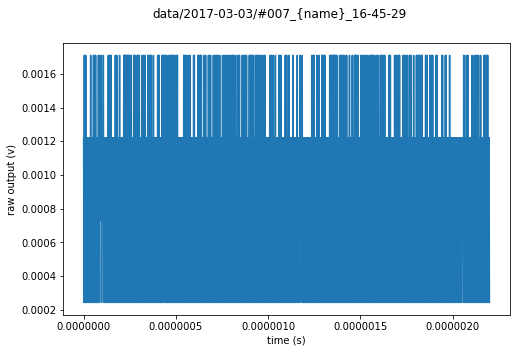

In [17]:
plot.fig

In [18]:
myctrl.int_delay(2e-7)
myctrl.int_time(6e-6)
myctrl.num_avg(1)

start 0 stop 2.2e-06 num steps 1152
start 0 stop 2.2e-06 num steps 3200


DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-03/#008_{name}_16-45-33'
   <Type>   | <array_id>                       | <array.name>       | <array.shape>
   Setpoint | time_set                         | time               | (3200,)
   Measured | my_controller_raw_output         | raw_output         | (3200,)
   Measured | my_controller_demod_freq_0_mag   | demod_freq_0_mag   | (3200,)
   Measured | my_controller_demod_freq_0_phase | demod_freq_0_phase | (3200,)
acquired at 2017-03-03 16:45:34


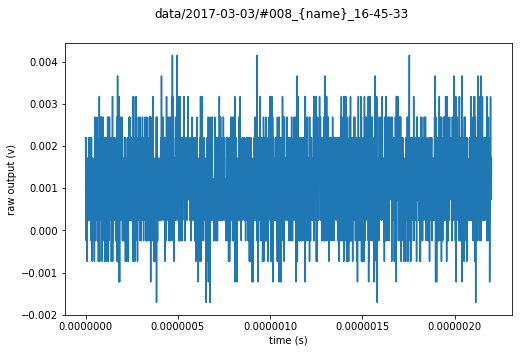

In [19]:
data3 = qc.Measure(myctrl.acquisition).run()
plot = qc.MatPlot(data3.my_controller_raw_output)
plot.fig

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-03/#009_{name}_16-45-34'
   <Type>   | <array_id>                       | <array.name>       | <array.shape>
   Setpoint | time_set                         | time               | (3200,)
   Measured | my_controller_raw_output         | raw_output         | (3200,)
   Measured | my_controller_demod_freq_0_mag   | demod_freq_0_mag   | (3200,)
   Measured | my_controller_demod_freq_0_phase | demod_freq_0_phase | (3200,)
acquired at 2017-03-03 16:45:35


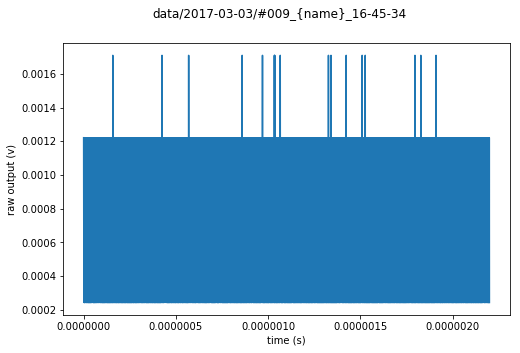

In [20]:
myctrl.num_avg(100)
data3 = qc.Measure(myctrl.acquisition).run()
plot = qc.MatPlot(data3.my_controller_raw_output)
plot.fig

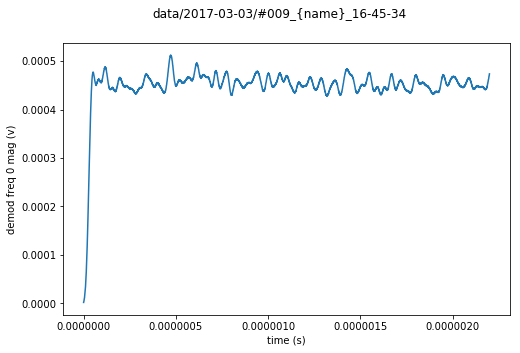

In [21]:
# Do this in as qcodes measurement (ie the same but makes a data set) _demod_freqs
#data3 = qc.Measure(basic_acq_controller.acquisition).run()
plot = qc.MatPlot(data3.my_controller_demod_freq_0_mag)
plot.fig

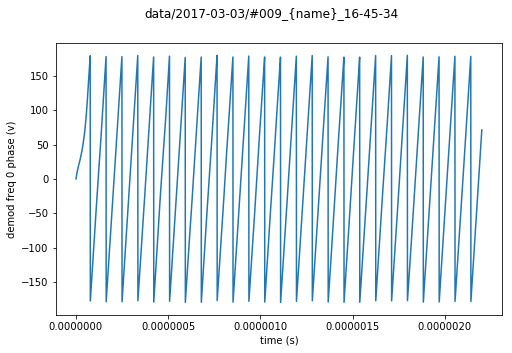

In [22]:
plot = qc.MatPlot(data3.my_controller_demod_freq_0_phase)
plot.fig

In [23]:
myctrl.demod_freqs.add_demodulator(400e6)

start 0 stop 6.2e-06 num steps 3200


DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-03/#010_{name}_16-45-37'
   <Type>   | <array_id>                       | <array.name>       | <array.shape>
   Setpoint | time_set                         | time               | (3200,)
   Measured | my_controller_raw_output         | raw_output         | (3200,)
   Measured | my_controller_demod_freq_0_mag   | demod_freq_0_mag   | (3200,)
   Measured | my_controller_demod_freq_0_phase | demod_freq_0_phase | (3200,)
   Measured | my_controller_demod_freq_1_mag   | demod_freq_1_mag   | (3200,)
   Measured | my_controller_demod_freq_1_phase | demod_freq_1_phase | (3200,)
acquired at 2017-03-03 16:45:38


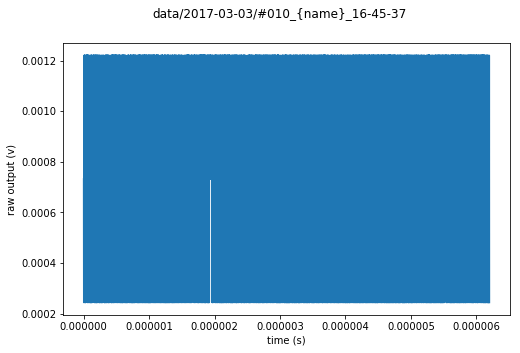

In [24]:
data3 = qc.Measure(myctrl.acquisition).run()
plot = qc.MatPlot(data3.my_controller_raw_output)
plot.fig

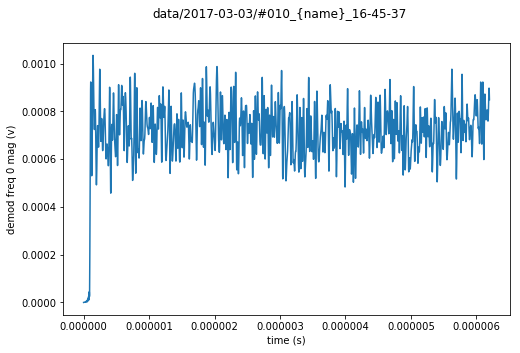

In [25]:
plot = qc.MatPlot(data3.my_controller_demod_freq_0_mag)
plot.fig

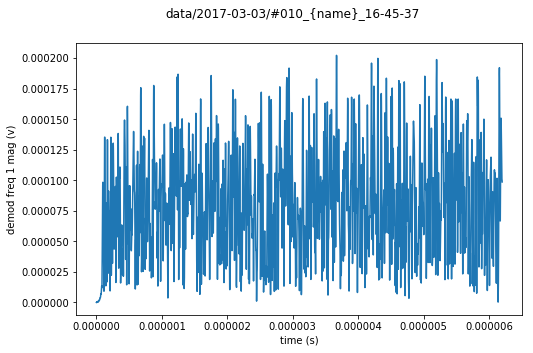

In [26]:
plot = qc.MatPlot(data3.my_controller_demod_freq_1_mag)
plot.fig

In [27]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to.
myintctrl = ATS9360Controller(name='my_controller_int', alazar_name='Alazar', integrate_samples=True)

In [28]:
myintctrl.int_delay(2e-7)
myintctrl.int_time(2e-6)
myintctrl.num_avg(100)

In [29]:
data4 = qc.Measure(myintctrl.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-03/#011_{name}_16-45-41'
   <Type>   | <array_id>                   | <array.name> | <array.shape>
   Setpoint | single_set                   | single       | (1,)
   Measured | my_controller_int_raw_output | raw_output   | (1,)
acquired at 2017-03-03 16:45:42


In [30]:
myintctrl.demod_freqs.add_demodulator(1e6)

In [31]:
data5 = qc.Measure(myintctrl.acquisition).run()

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2017-03-03/#012_{name}_16-45-42'
   <Type>   | <array_id>                           | <array.name>       | <array.shape>
   Setpoint | single_set                           | single             | (1,)
   Measured | my_controller_int_raw_output         | raw_output         | (1,)
   Measured | my_controller_int_demod_freq_0_mag   | demod_freq_0_mag   | (1,)
   Measured | my_controller_int_demod_freq_0_phase | demod_freq_0_phase | (1,)
acquired at 2017-03-03 16:45:43


In [32]:
myrecctrl = ATS9360Controller(name='my_controller_rec', alazar_name='Alazar', 
                              integrate_samples=True, average_records=False)

In [33]:
myrecctrl.int_delay(2e-7)
myrecctrl.int_time(2e-6)
myrecctrl.num_avg(100)
data6 = qc.Measure(myrecctrl.acquisition).run()

ValueError: Wrong number of inputs supplied

In [36]:
myrecctrl.acquisition.setpoints

((),)